# Theano, Lasagne
и с чем их едят

# разминка
* напиши на numpy функцию, которая считает сумму квадратов чисел от 0 до N, где N - аргумент
* массив чисел от 0 до N - numpy.arange(N)

In [3]:
from sklearn.cross_validation import train_test_split
from skimage import transform as tf

In [4]:
import numpy as np
def sum_squares(N):
    return np.sum(np.arange(N) ** 2)

In [7]:
%%time
sum_squares(10**8)

CPU times: user 465 ms, sys: 456 ms, total: 921 ms
Wall time: 1.08 s


662921401752298880

# theano teaser

Как сделать то же самое

In [5]:
import theano
import theano.tensor as T

In [13]:


#будущий параметр функции
N = T.scalar("a dimension",dtype='int32')


#рецепт получения суммы квадратов
result = (T.arange(N)**2).sum()

#компиляция функции "сумма квадратов" чисел от 0 до N
sum_function = theano.function(inputs=[N], outputs=result)

In [14]:
%%time
sum_function(10**8)

CPU times: user 224 ms, sys: 0 ns, total: 224 ms
Wall time: 454 ms


array(20047455266176)

# Как оно работает?
* Нужно написать "рецепт" получения выходов по входам
* То же самое на заумном: нужно описать символический граф вычислений


* 2 вида зверей - "входы" и "преобразования"
* Оба могут быть числами, массивами, матрицами, тензорами и т.п.


* Вход - это то аргумент функции. То место, на которое подставится аргумент вызове.
 * N - вход в примере выше


* Преобразования - рецепты вычисления чего-то на основе входов и констант
 * (T.arange(N)^2).sum() - 3 последовательных преобразования N
 * Работают почти 1 в 1 как векторные операции в numpy
 * почти всё, что есть в numpy есть в theano tensor и называется так же
   * np.mean -> T.mean
   * np.arange -> T.arange
   * np.cumsum -> T.cumsum
   * и так далее...
   * Совсем редко - бывает, что меняется название или синтаксис - нужно спросить у семинаристов или гугла
 
 
Ничего не понятно? Сейчас исправим.

In [15]:
#входы
example_input_integer = T.scalar("вход - одно число(пример)",dtype='float32')

example_input_tensor = T.tensor4("вход - четырёхмерный тензор(пример)")
#не бойся, тензор нам не пригодится



input_vector = T.vector("вход - вектор целых чисел", dtype='int32')


In [16]:
#преобразования

#поэлементное умножение
double_the_vector = input_vector*2

#поэлементный косинус
elementwise_cosine = T.cos(input_vector)

#разность квадрата каждого элемента и самого элемента
vector_squares = input_vector**2 - input_vector


In [17]:
double_the_vector

Elemwise{mul,no_inplace}.0

In [18]:
#теперь сам:
#создай 2 вектора из чисел float32
my_vector = T.vector(dtype='float32')
my_vector2 = T.vector(dtype='float32')

In [19]:
#напиши преобразование, которое считает
#(вектор 1)*(вектор 2) / (sin(вектор 1) +1)
my_transformation = my_vector * my_vector2 / (T.sin(my_vector) + 1)

In [20]:
print (my_transformation)
#то, что получилась не чиселка - это нормально

Elemwise{true_div,no_inplace}.0


# Компиляция
* До этого момента, мы использовали "символические" переменные
 * писали рецепт вычислений, но ничего не вычисляли
* чтобы рецепт можно было использовать, его нужно скомпилировать

In [21]:
inputs = [my_vector, my_vector2]
outputs = [my_transformation]

# можно скомпилировать написанные нами преобразования как функцию
my_function = theano.function(
    inputs,outputs,
    allow_input_downcast=True #автоматически прводить типы (необязательно)
 )

In [22]:
#можно вызвать вот-так:
print ("using python lists:")
print (my_function([1,2,3],[4,5,6]))
print()

#а можно так. 
#К слову, ту тип float приводится к типу второго вектора
print ("using numpy arrays:")
print (my_function(np.arange(10),
                  np.linspace(5,6,10,dtype='float')))


using python lists:
[array([  2.1721766 ,   5.23752832,  15.77397728], dtype=float32)]
()
using numpy arrays:
[array([   0.        ,    2.77555895,    5.47030783,   14.02131271,
         89.5477066 ,  676.25805664,   47.183918  ,   24.4084301 ,
         23.68156242,   38.24041748], dtype=float32)]


# хинт для отладки
* Если ваша функция большая, компиляция может отнять какое-то время.
* Чтобы не ждать, можно посчитать выражение без компиляции
* Вы экономите время 1 раз на компиляции, но сам код выполняется медленнее


In [24]:
#словарик значений для входов
my_function_inputs = {
    my_vector:[1,2,3],
    my_vector2:[4,5,6]
}

#вычислить без компиляции
#если мы ничего не перепутали, 
#должно получиться точно то же, что и раньше
print my_transformation.eval(my_function_inputs)


#можно вычислять преобразования на ходу
print "сумма 2 векторов", (my_vector + my_vector2).eval(my_function_inputs)

#!ВАЖНО! если преобразование зависит только от части переменных,
#остальные давать не надо
print "форма первого вектора", my_vector.shape.eval({
        my_vector:[1,2,3]
    })


[  2.1721766    5.23752832  15.77397728]
сумма 2 векторов [ 5.  7.  9.]
форма первого вектора [3]


* Для отладки желательно уменьшить масштаб задачи. Если вы планировали послать на вход вектор из 10^9 примеров, пошлите 10~100.
* Если #ОЧЕНЬ нужно послать большой вектор, быстрее скомпилировать функцию обычным способом

# Теперь сам: MSE (2 pts)

In [30]:
# Задание 1 - напиши и скомпилируй theano-функцию, которая считает среднеквадратичную ошибку двух векторов-входов
# Вернуть нужно одно число - собственно, ошибку. Обновлять ничего не нужно
my_vector = T.vector(dtype='float32')
my_vector2 = T.vector(dtype='float32')
mse_transformation = ((my_vector - my_vector2) ** 2).sum() * 1. / my_vector.shape[0]

compute_mse = theano.function([my_vector, my_vector2], mse_transformation, allow_input_downcast=True)

In [31]:
#тесты
from sklearn.metrics import mean_squared_error

for n in [1,5,10,10**3]:
    
    elems = [np.arange(n),np.arange(n,0,-1), np.zeros(n),
             np.ones(n),np.random.random(n),np.random.randint(100,size=n)]
    
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el,el_2))
            my_mse = compute_mse(el,el_2)
            if not np.allclose(true_mse,my_mse):
                print ('Wrong result:')
                print ('mse(%s,%s)'%(el,el_2))
                print ("should be: %f, but your function returned %f"%(true_mse,my_mse))
                raise ValueError("Что-то не так")

print ("All tests passed")
            
    

All tests passed


# Shared variables

* Входы и преобразования - части рецепта. 
 * Они существуют только во время вызова функции.


* Shared переменные - всегда остаются в памяти
 * им можно поменять значение 
   * (но не внутри символического графа. Об этом позже)
 * их можно включить в граф вычислений
 
 
* хинт - в таких переменных удобно хранить параметры и гиперпараметры
 * например, веса нейронки или learning rate, если вы его меняете

In [32]:
#cоздадим расшаренную перменную
shared_vector_1 = theano.shared(np.ones(10,dtype='float64'))

In [35]:

#получить (численное) значение переменной
print "initial value",shared_vector_1.get_value()

initial value [ 0.  1.  2.  3.  4.]


In [36]:
#задать новое значение
shared_vector_1.set_value( np.arange(5) )

#проверим значение
print "new value", shared_vector_1.get_value()

#Заметь, что раньше это был вектор из 10 элементов, а сейчас - из 5. 
#Если граф при этом остался выполним, это сработает.

new value [ 0.  1.  2.  3.  4.]


# Теперь сам

In [38]:
#напиши рецепт (преобразование), которое считает произведение(поэллементное) shared_vector на input_scalar
#скомпилируй это в функцию от input_scalar

input_scalar = T.scalar('coefficient',dtype='float32')

scalar_times_shared = shared_vector_1 * input_scalar


shared_times_n = theano.function([input_scalar], scalar_times_shared, allow_input_downcast=True)


In [39]:
print ("shared:", shared_vector_1.get_value())

print ("shared_times_n(5)",shared_times_n(5))

print ("shared_times_n(-0.5)",shared_times_n(-0.5))


('shared:', array([ 0.,  1.,  2.,  3.,  4.]))
('shared_times_n(5)', array([  0.,   5.,  10.,  15.,  20.]))
('shared_times_n(-0.5)', array([-0. , -0.5, -1. , -1.5, -2. ]))


In [40]:
#поменяем значение shared_vector_1
shared_vector_1.set_value([-1,0,1])
print ("shared:", shared_vector_1.get_value())

print ("shared_times_n(5)",shared_times_n(5))

print ("shared_times_n(-0.5)",shared_times_n(-0.5))


('shared:', array([-1.,  0.,  1.]))
('shared_times_n(5)', array([-5.,  0.,  5.]))
('shared_times_n(-0.5)', array([ 0.5, -0. , -0.5]))


# T.grad, самое вкусное
* theano умеет само считать производные. Все, которые существуют.
* Производные считаются в символическом, а не численном виде

Ограничения
* За раз можно считать производную __скалярной__ функции по одной или нескольким скалярным или векторным аргументам
* Функция должна на всех этапах своего вычисления иметь тип float32 или float64 (т.к. на множестве целых чисел производная не имеет смысл)

In [41]:
my_scalar = T.scalar(name='input',dtype='float64')

scalar_squared = T.sum(my_scalar**2)

#производная v_squared по my_vector
derivative = T.grad(scalar_squared,my_scalar)

fun = theano.function([my_scalar],scalar_squared)
grad = theano.function([my_scalar],derivative) 

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

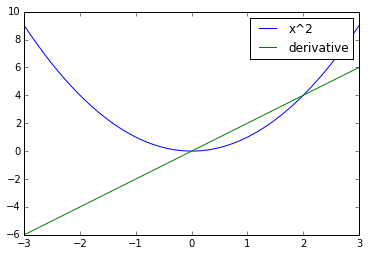

In [42]:
x = np.linspace(-3,3)
x_squared = list(map(fun,x))
x_squared_der = list(map(grad,x))

plt.plot(x, x_squared,label="x^2")
plt.plot(x, x_squared_der, label="derivative")
plt.legend()

# теперь сам

In [43]:

my_vector = T.vector('float64')

#посчитай производные этой функции по my_scalar и my_vector
#warning! Не пытайся понять физический смысл этой функции
weird_psychotic_function = ((my_vector+my_scalar)**(1+T.var(my_vector)) +1./T.arcsinh(my_scalar)).mean()/(my_scalar**2 +1) + 0.01*T.sin(2*my_scalar**1.5)*(T.sum(my_vector)* my_scalar**2)*T.exp((my_scalar-4)**2)/(1+T.exp((my_scalar-4)**2))*(1.-(T.exp(-(my_scalar-4)**2))/(1+T.exp(-(my_scalar-4)**2)))**2


der_by_scalar,der_by_vector = [T.grad(weird_psychotic_function,my_scalar), T.grad(weird_psychotic_function, my_vector)]


compute_weird_function = theano.function([my_scalar,my_vector],weird_psychotic_function)
compute_der_by_scalar = theano.function([my_scalar,my_vector],der_by_scalar)


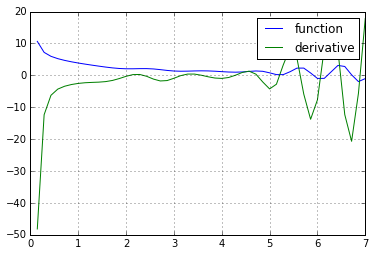

In [44]:
#график функции и твоей производной
vector_0 = [1,2,3]

scalar_space = np.linspace(0,7)

y = [compute_weird_function(x,vector_0) for x in scalar_space]
plt.plot(scalar_space,y,label='function')
y_der_by_scalar = [compute_der_by_scalar(x,vector_0) for x in scalar_space]
plt.plot(scalar_space,y_der_by_scalar,label='derivative')
plt.grid();plt.legend()


# Последний штрих - Updates

* updates - это способ изменять значения shared переменных каждый раз В КОНЦЕ вызова функции

* фактически, это словарь {shared_переменная: рецепт нового значения}, который добавляется в функцию при компиляции

Например,

In [45]:
#умножим shared вектор на число и сохраним новое значение обратно в этот shared вектор

inputs = [input_scalar]
outputs = [scalar_times_shared] #вернём вектор, умноженный на число

my_updates = {
    shared_vector_1:scalar_times_shared #и этот же результат запишем в shared_vector_1
}

compute_and_save = theano.function(inputs, outputs, updates=my_updates)

In [46]:
shared_vector_1.set_value(np.arange(5))

#изначальное значение shared_vector_1
print ("initial shared value:" ,shared_vector_1.get_value())

# теперь вычислим функцию (значение shared_vector_1 при этом поменяется)
print ("compute_and_save(2) returns",compute_and_save(2))

#проверим, что в shared_vector_1
print ("new shared value:" ,shared_vector_1.get_value())



('initial shared value:', array([ 0.,  1.,  2.,  3.,  4.]))
('compute_and_save(2) returns', [array([ 0.,  2.,  4.,  6.,  8.])])
('new shared value:', array([ 0.,  2.,  4.,  6.,  8.]))


# Логистическая регрессия
Что нам потребуется:
* Веса лучше хранить в shared-переменной
* Данные можно передавать как input
* Нужно 2 функции:
 * train_function(X,y) - возвращает ошибку и изменяет веса на 1 шаг по граиденту __(через updates)__
 * predict_fun(X) - возвращает предсказанные ответы ("y") по данным

In [88]:
from skimage import io

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


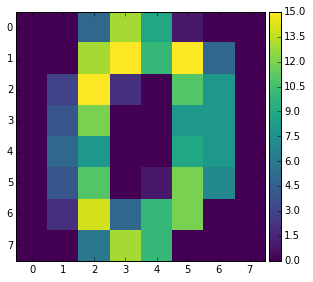

In [90]:
io.imshow(X[0].reshape((8, 8)))

In [81]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X,y = mnist.data, mnist.target


print "y [форма - %s]:"%(str(y.shape)),y[:10]

print "X [форма - %s]:"%(str(X.shape))
print X[:3]

y [форма - (360,)]: [0 1 0 1 0 1 0 0 1 1]
X [форма - (360, 64)]:
[[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.
    5.   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.
    0.   8.   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.
   11.   0.   1.  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.
    0.   0.   6.  13.  10.   0.   0.   0.]
 [  0.   0.   0.  12.  13.   5.   0.   0.   0.   0.   0.  11.  16.   9.
    0.   0.   0.   0.   3.  15.  16.   6.   0.   0.   0.   7.  15.  16.
   16.   2.   0.   0.   0.   0.   1.  16.  16.   3.   0.   0.   0.   0.
    1.  16.  16.   6.   0.   0.   0.   0.   1.  16.  16.   6.   0.   0.
    0.   0.   0.  11.  16.  10.   0.   0.]
 [  0.   0.   1.   9.  15.  11.   0.   0.   0.   0.  11.  16.   8.  14.
    6.   0.   0.   2.  16.  10.   0.   9.   9.   0.   0.   1.  16.   4.
    0.   8.   8.   0.   0.   4.  16.   4.   0.   8.   8.   0.   0.   1.
   16.   5.   1.  11.   3.   0.   0.   0.  12.  12.  10. 

In [82]:
# for i in range(len(y)):
#     if y[i] == 0:
#         y[i] = -1


from sklearn.preprocessing import OneHotEncoder


y = y.reshape(-1, 1)

one_hot = OneHotEncoder()
y = one_hot.fit_transform(y)

In [83]:
# переменные и входы
shared_weights = theano.shared(np.random.random((X.shape[1], 2)))
input_X = T.matrix(dtype="float32")
input_y = T.matrix(dtype="float32")

In [84]:
# predicted_y = 1./ (1 + T.exp( - T.dot(input_X, shared_weights)))
predicted_y = T.nnet.softmax(T.dot(input_X, shared_weights))
# loss = T.log(1 + T.exp(- input_y * T.dot(input_X, shared_weights))).sum()
loss = - T.mean(input_y * T.log(predicted_y))

grad = T.grad(loss, shared_weights)

updates = {
    shared_weights: shared_weights - grad * 0.01
}

In [85]:
train_function = theano.function([input_X, input_y], loss, updates=updates, allow_input_downcast=True)
# <функция, которая по X и Y возвращает ошибку и обновляет веса>
predict_function = theano.function([input_X], predicted_y, allow_input_downcast=True)
# <функция, которая по X считает предсказание для y>

In [86]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

loss at iter 0: 0.3588
('train auc:', 0.94976943346508569)
('test auc:', 0.97727272727272729)
loss at iter 1: 0.3184
('train auc:', 0.95863526570048319)
('test auc:', 0.98221343873517786)
loss at iter 2: 0.2858
('train auc:', 0.96508563899868249)
('test auc:', 0.98715415019762853)
loss at iter 3: 0.2587
('train auc:', 0.96983421168203776)
('test auc:', 0.99061264822134387)
loss at iter 4: 0.2356
('train auc:', 0.97381422924901173)
('test auc:', 0.9925889328063241)
resulting weights:


<matplotlib.colorbar.Colorbar instance at 0x7f68b2954dd0>

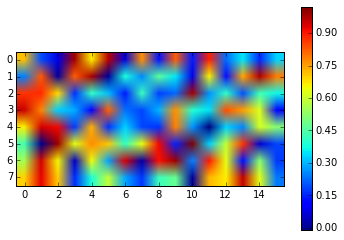

In [57]:
from sklearn.metrics import roc_auc_score

for i in range(5):
    loss_i = train_function(X_train, y_train)
    print ("loss at iter %i: %.4f"%(i,loss_i))
    a = predict_function(X_train)
    print ("train auc:",roc_auc_score(y_train,predict_function(X_train)))
    print ("test auc:",roc_auc_score(y_test,predict_function(X_test)))

    
print ("resulting weights:")
plt.imshow(shared_weights.get_value().reshape(8,-1))
plt.colorbar()

# lasagne
* lasagne - это библиотека для написания нейронок произвольной формы на theano
* библиотека низкоуровневая, границы между theano и lasagne практически нет

В качестве демо-задачи выберем то же распознавание чисел, но на большем масштабе задачи
* картинки 28x28
* 10 цифр

In [4]:
from sklearn.datasets import fetch_mldata
from skimage import io

In [5]:
mnist = fetch_mldata('MNIST original', data_home='.')

In [6]:
X = mnist.data.reshape((70000, 1, 28, 28))
y = mnist.target

In [98]:
def rotate_img(img, angle=-10):
    tform = tf.SimilarityTransform(scale=1, rotation=np.pi * angle / 180, translation=(0, 1))
    img = tf.warp(img, inverse_map=tform.inverse, output_shape=img.shape)
    return np.array(img)

In [100]:
X_rotated = []
for i in range(len(X)):
    X_rotated.append(rotate_img(X[i], angle=-5))
for i in range(len(X)):
    X_rotated.append(rotate_img(X[i], angle=5))

In [101]:
X_rotated = np.concatenate([X, X_rotated])
X_rotated = X_rotated.reshape((210000, 1, 28, 28))
y_rotated = np.concatenate([y, y, y])

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y)

In [8]:

import theano
import theano.tensor as T
import lasagne

input_X = T.tensor4("X")

#размерность входа (None означает "может изменяться")
input_shape = [None,1,28,28]

target_y = T.vector("target Y integer",dtype='int32')

Так задаётся архитектура нейронки

In [9]:
from lasagne.nonlinearities import *
from lasagne.layers import *

In [10]:
input_shape

[None, 1, 28, 28]

In [11]:
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=input_X)
    # This time we do not apply input dropout, as it tends to work less well
    # for convolutional layers.

    # Convolutional layer with 32 kernels of size 5x5. Strided and padded
    # convolutions are supported as well; see the docstring.
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
#     network = dropout(network, p=0.5)
    # Expert note: Lasagne provides alternative convolutional layers that
    # override Theano's choice of which implementation to use; for details
    # please see http://lasagne.readthedocs.org/en/latest/user/tutorial.html.

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # Another convolution with 32 5x5 kernels, and another 2x2 pooling:
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=256,
            nonlinearity=lasagne.nonlinearities.rectify)

    # And, finally, the 10-unit output layer with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)



In [141]:
#входной слой (вспомогательный)
input_layer = InputLayer(shape=input_shape, input_var=input_X)

#полносвязный слой, который принимает на вход input layer и имеет 100 нейронов.
# нелинейная функция - сигмоида как в логистической регрессии
# слоям тоже можно давать имена, но это необязательно
# dense_1 = lasagne.layers.DenseLayer(input_layer,num_units=50,
#                                    nonlinearity = lasagne.nonlinearities.sigmoid,
#                                    name = "hidden_dense_layer")
# network = lasagne.layers.dnn.Conv2DDNNLayer(input_layer, 32, filter_size=(3, 3), pad='same', nonlinearity=rectify, name="conv1")
network = Conv2DLayer(input_layer, 16, filter_size=(3,3), pad='same', nonlinearity=rectify, name="conv1")
network = MaxPool2DLayer(network, pool_size=(2,2), stride=2, name="pool1")
# network = BatchNormLayer(network, name="bn1")
network = dropout(network, p=0.5)

# network = lasagne.layers.batch_norm(lasagne.layers.dnn.Conv2DDNNLayer(network, num_filters=64, filter_size=(2, 2), stride=1, nonlinearity=rectify, name="conv2"))
network = batch_norm(Conv2DLayer(network, num_filters=32, filter_size=(2,2), nonlinearity=rectify, name="conv2"))
# network2 = lasagne.layers.dropout(network, p=0.2)

# network = dnn.Conv2DDNNLayer(incoming=network, num_filters=64, filter_size=(3, 3), pad='same', stride=1, nonlinearity=rectify, name="conv2")
# network = Conv2DLayer(incoming=network, num_filters=64, filter_size=(2, 2), pad='same', stride=1, nonlinearity=rectify, name="conv2")
network = MaxPool2DLayer(network, pool_size=(2,2), stride=2, pad=1, name="pool2")
# network = lasagne.layers.BatchNormLayer(incoming=network, name="bn2")

network = DenseLayer(incoming=network, num_units=64, nonlinearity=rectify, name="dense1")
# network = DenseLayer(incoming=network, num_units=100, nonlinearity=rectify, name="dense1")
# network2 = BatchNormLayer(incoming=network2, name="bm_last")

#ВЫХОДНОЙ полносвязный слой, который принимает на вход dense_1 и имеет 10 нейронов -по нейрону на цифру
#нелинейность - softmax - чтобы вероятности всех цифр давали в сумме 1
dense_output = DenseLayer(network,num_units = 10,
                                        nonlinearity = softmax,
                                        name='output')


In [12]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(network)

/notebooks/rl/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode=self.mode,
/notebooks/rl/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode=self.mode,
/notebooks/rl/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode=self.mode,


In [13]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(network, trainable=True)
print (all_weights)

[W, b, W, b, W, b, W, b]


### дальше вы могли бы просто
* задать функцию ошибки вручную
* посчитать градиент ошибки по all_weights
* написать updates
* но это долго, а простой шаг по градиенту - не самый лучший смособ оптимизировать веса

Вместо этого, опять используем lasagne

In [14]:
learning_rate = T.scalar(name='learning_rate')

In [15]:
#функция ошибки - средняя кроссэнтропия
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()
loss += lasagne.regularization.regularize_network_params(network, lasagne.regularization.l2) * 2e-3
# l2_penalty = regularize_layer_params(dense_output, l2) * 1e-3

accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
updates_sgd = lasagne.updates.adam(loss, all_weights, learning_rate=learning_rate)
updates = lasagne.updates.nesterov_momentum(loss, all_weights, learning_rate=0.01, momentum=0.9)

In [18]:
#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X,target_y, learning_rate],[loss,accuracy],updates=updates_sgd, allow_input_downcast=True)

#функция, которая считает точность
accuracy_fun = theano.function([input_X,target_y],accuracy, allow_input_downcast=True)

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


### Вот и всё, пошли её учить
* данных теперь много, поэтому лучше учиться стохастическим градиентным спуском
* для этого напишем функцию, которая бьёт выпорку на мини-батчи (в обычном питоне, не в theano)

In [20]:
# вспомогательная функция, которая возвращает список мини-батчей для обучения нейронки

#на вход
# X - тензор из картинок размером (много, 1, 28, 28), например - X_train
# y - вектор из чиселок - ответов для каждой картинки из X; например - Y_train
#batch_size - одно число - желаемый размер группы

#что нужно сделать
# 1) перемешать данные
# - важно перемешать X и y одним и тем же образом, чтобы сохранить соответствие картинки ответу на неё
# 3) побить данные на подгруппы так, чтобы в каждой подгруппе было batch_size картинок и ответов
# - если число картинок не делится на batch_size, одну подгруппу можно вернуть другого размера
# 4) вернуть список (или итератор) пар:
# - (подгруппа картинок, ответы из y на эту подгруппу)
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
    
#
# Всё плохо и ты не понимаешь, что от тебя хотят?
# можешь поискать похожую функцию в примере
# https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py

# Процесс обучения

In [65]:
import time

num_epochs = 100 #количество проходов по данным

batch_size = 500 #размер мини-батча

for epoch in range(num_epochs):
    
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size, shuffle=True):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 100 took 160.377s
  training loss (in-iteration):		0.034418
  train accuracy:		98.90 %
  validation accuracy:		98.46 %
Epoch 2 of 100 took 168.162s
  training loss (in-iteration):		0.034445
  train accuracy:		98.90 %
  validation accuracy:		98.36 %
Epoch 3 of 100 took 161.797s
  training loss (in-iteration):		0.034997
  train accuracy:		98.88 %
  validation accuracy:		98.41 %
Epoch 4 of 100 took 161.950s
  training loss (in-iteration):		0.032385
  train accuracy:		98.90 %
  validation accuracy:		98.46 %
Epoch 5 of 100 took 164.166s
  training loss (in-iteration):		0.032802
  train accuracy:		99.00 %
  validation accuracy:		98.57 %
Epoch 6 of 100 took 157.994s
  training loss (in-iteration):		0.031661
  train accuracy:		99.01 %
  validation accuracy:		98.57 %
Epoch 7 of 100 took 161.156s
  training loss (in-iteration):		0.031023
  train accuracy:		98.97 %
  validation accuracy:		98.55 %
Epoch 8 of 100 took 166.424s
  training loss (in-iteration):		0.031178
  train accuracy:		

In [ ]:
import time

num_epochs = 100 #количество проходов по данным

batch_size = 512 #размер мини-батча

learning_rate = 0.0005

for epoch in range(num_epochs):
    if epoch % 50:
        learning_rate /= 2.
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets, learning_rate)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

In [22]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_val, y_val, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print ("Achievement unlocked: колдун 80 уровня")
else:
    print ("Нужно больше магии!")

Final results:
  test accuracy:		98.82 %
Нужно больше магии!


# Нейронка твоей мечты


* Задача - сделать нейронку, которая получит точность 99% на валидации (validation accuracy)
 * __+1 балл__ за каждые 0.2% сверх 99%
 * Вариант "is fine too" - 97.5%. 
 * Чем выше, тем лучше.
 
__ В конце есть мини-отчётик, который имеет смысл прочитать вначале и заполнять по ходу работы. __
 

## Что можно улучшить:



 * размер сети
   * бОльше нейронов, 
   * бОльше слоёв, 
   * почти наверняка нужны свёртки
   * Пх'нглуи мглв'нафх Ктулху Р'льех вгах'нагл фхтагн! 
   
   
   
 * регуляризация - чтобы не переобучалось
   * приплюсовать к функции ошибки какую-нибудь сумму квадратов весов
   * можно сделать вручную, а можно - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   
   
   
 * Метод оптимизации - rmsprop, nesterov_momentum, adadelta, adagrad и т.п.
   * сходятся быстрее и иногда - к лучшему оптимуму
   * имеет смысл поиграть с размером батча, количеством эпох и скоростью обучения
   
   
   
 * Dropout - для борьбы с переобучением
   * `lasagne.layers.DropoutLayer(предыдущий_слой, p=вероятность_занулить)`
   
   
   
 * Свёрточные слои 
   * `network = lasagne.layers.Conv2DLayer(предыдущий_слой,`
    `                       num_filters = число нейронов,`
    `                        filter_size = (ширина_квадрата, высота_квадрата),`
    `                        nonlinearity = нелинейная_функция)`
   * ВАРНУНГ! могут учиться долго на CPU
     * Однако мы всё равно рекоммендуем обучить хотя бы маленькую свёртку
 
 * Любые другие слои и архитектуры
   * http://lasagne.readthedocs.org/en/latest/modules/layers.html
   * Pooling, Batch Normalization, etc
   
   
 * Наконец, можно поиграть с нелинейностями в скрытых слоях
   * tanh, relu, leaky relu, etc
 
 
   
Для удобства, ниже есть заготовка решения, которое можно заполнять, а можно выкинуть и написать своё

** У меня было несколько вариантов (разные слои, нелинейности, batch_norm и т.д), на которых точность была примерно 98, и в итоге я взяла сетку с гитхаба из примеров лазаньи, добавила l2 регуляризацию и сделала уменьшающийся во времени learning rate. Но, как видите, у меня все равно не вышло обучить ее достаточно хорошо( **|

Не знаю, что еще тут детально описывать, кажется, все ясно. Слишком глубокую делать не стала, проиницализировала xavier (по фен-шую), в качестве нелинейности использовала relu, аугументировала данные поворотами на +-5 (почему-то стало хуже). Пробоваа разные оптимизаторы, в итоге пришла к идее, что надо уменьшать learning rate. Делала домашку в общей сумме неделю, может, больше, но так и не добилась больше 99, что бы ни пробовала. Обидно(( 